In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.rcParams.update({ 'font.size': 14 })

In [2]:
df = pd.read_csv('../basic_cnn_results2.csv')
datasets = sorted(df.Train.unique())

In [3]:
def label_for(ds):
  if 'single' in ds:
    s = f"80,000 steps * 1 run\n(restart {1+int('2' in ds)})"
  else:
    s = '80 steps * 1000 runs\n(sample '
    if 'uniform' in ds:
      s += 'every 1K)'
    else:
      s += 'irregularly)'
  return s

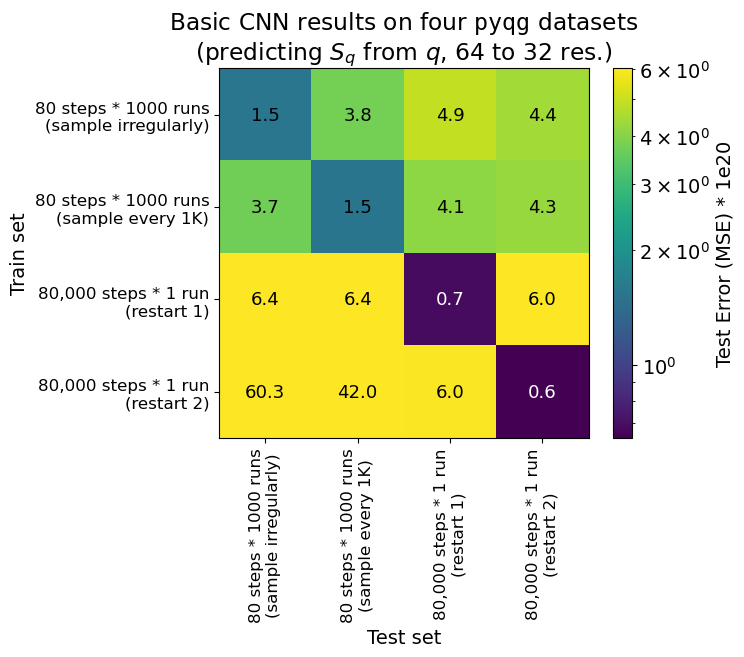

In [4]:
grid = np.array([[
  df[(df.Train==d1)&(df.Test==d2)].MSE.values[0]
    for d2 in datasets]
    for d1 in datasets]) * 1e20

plt.imshow(grid, norm=colors.LogNorm(vmin=grid.min(), vmax=grid.max()/10))
for i, row in enumerate(grid):
  for j, val in enumerate(row):
    plt.text(j,i,f"{val:.1f}",ha='center',va='center',fontsize=13,color=('white' if val<1 else 'black'))
labels = list(map(label_for, datasets))
plt.xticks(range(len(datasets)), labels, rotation=90, fontsize=12)
plt.yticks(range(len(datasets)), labels, fontsize=12)
plt.ylabel("Train set")
plt.xlabel("Test set")
plt.colorbar(label='Test Error (MSE) * 1e20')
plt.title("Basic CNN results on four $\mathtt{pyqg}$ datasets\n(predicting $S_q$ from $q$, 64 to 32 res.)")
plt.show()

In [5]:
import sys; sys.path.append('..')
from pyqg_subgrid_dataset import PYQGSubgridDataset
from models import *
from figure_grid import *

In [6]:
import os

pyqg_dir = '/scratch/zanna/data/pyqg'

def load_model(path):
    shape = (1, 32, 32)
    net = BasicCNN(shape, shape)
    net.load(path+'/basic_cnn2')
    return net

models = [
    load_model(os.path.join(pyqg_dir, ds))
    for ds in datasets
]

datasets = [
    PYQGSubgridDataset(os.path.join(pyqg_dir, ds))
    for ds in datasets
]

/ext3/miniconda3/envs/m2lines/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
dirs = [ds.name for ds in datasets]
dirs

['many_runs_few_steps_irregular',
 'many_runs_few_steps_uniform',
 'single_run_all_steps',
 'single_run_all_steps2']

In [8]:
def minibatch(inputs, targets, batch_size=64, as_tensor=True, shuffle=True):
    assert len(inputs) == len(targets)
    order = np.arange(len(inputs))
    if shuffle:
        np.random.shuffle(order)
    steps = int(np.ceil(len(inputs) / batch_size))
    xform = torch.as_tensor if as_tensor else lambda x: x
    for step in range(steps):
        idx = order[step*batch_size:(step+1)*batch_size]
        x = xform(inputs[idx])
        y = xform(targets[idx])
        yield x, y

In [9]:
from collections import defaultdict
times = {}
runs = {}
errors = defaultdict(dict)

for ds in datasets:
    print(ds.name)
    
    x = ds.to_np(ds.dataset.coarse_data.potential_vorticity)
    y = ds.to_np(ds.dataset.forcing_data.potential_vorticity)
    order = ds.persistent_order
    split_at = int(len(x)*0.25)
    train = order[split_at:]
    test = order[:split_at]
    x = x[test]
    y = y[test]
    times[ds.name] = ds.dataset.time_idxs[test]
    runs[ds.name] = ds.dataset.run_idxs[test]
    
    for model, mdir in zip(models, dirs):
        print('  ' + mdir)
        errs = []
        for xb, yb in minibatch(x, y, as_tensor=False, shuffle=False):
            errs.append(np.sum((yb-model.predict(xb))**2, axis=1))        
        errors[ds.name][mdir] = np.hstack(errs)

many_runs_few_steps_irregular
  many_runs_few_steps_irregular
  many_runs_few_steps_uniform
  single_run_all_steps
  single_run_all_steps2
many_runs_few_steps_uniform
  many_runs_few_steps_irregular
  many_runs_few_steps_uniform
  single_run_all_steps
  single_run_all_steps2
single_run_all_steps
  many_runs_few_steps_irregular
  many_runs_few_steps_uniform
  single_run_all_steps
  single_run_all_steps2
single_run_all_steps2
  many_runs_few_steps_irregular
  many_runs_few_steps_uniform
  single_run_all_steps
  single_run_all_steps2


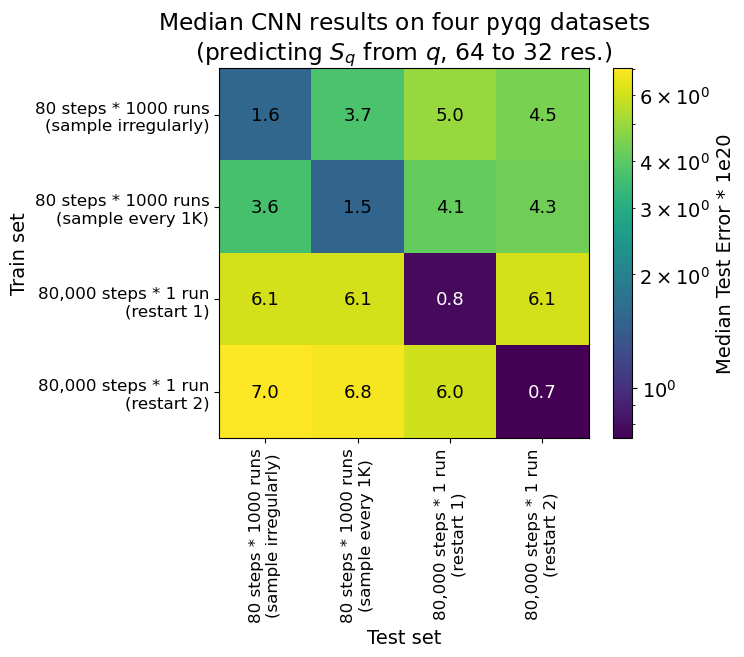

In [10]:
grid = np.array([[
  np.median(errors[d2.name][d1.name])
    for d2 in datasets]
    for d1 in datasets]) * 1e20

plt.imshow(grid, norm=colors.LogNorm(vmin=grid.min(), vmax=grid.max()))
for i, row in enumerate(grid):
  for j, val in enumerate(row):
    plt.text(j,i,f"{val:.1f}",ha='center',va='center',fontsize=13,color=('white' if val<1 else 'black'))
labels = [label_for(d.name) for d in datasets]
plt.xticks(range(len(datasets)), labels, rotation=90, fontsize=12)
plt.yticks(range(len(datasets)), labels, fontsize=12)
plt.ylabel("Train set")
plt.xlabel("Test set")
plt.colorbar(label='Median Test Error * 1e20')
plt.title("Median CNN results on four $\mathtt{pyqg}$ datasets\n(predicting $S_q$ from $q$, 64 to 32 res.)")
plt.show()

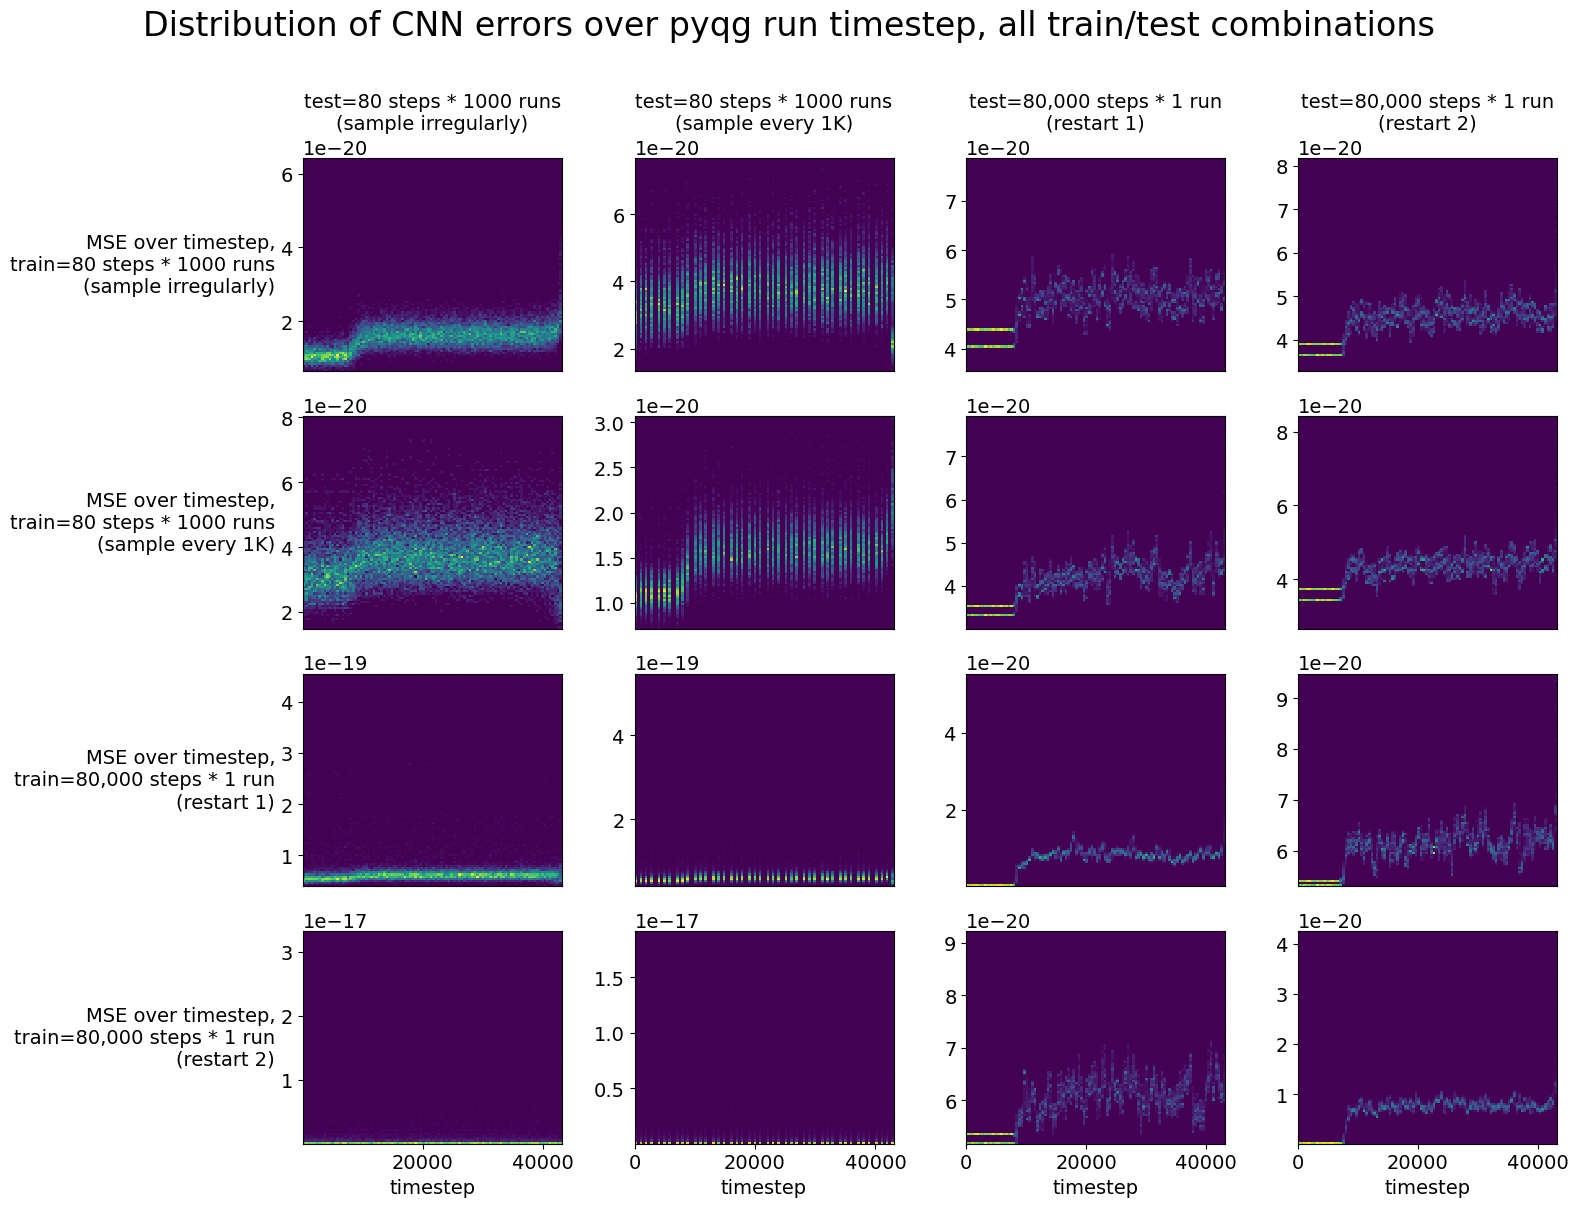

In [11]:
with figure_grid(4,4,rowwidth=16) as g:
    g.title("Distribution of CNN errors over pyqg run timestep, all train/test combinations", fontsize=24, y=0.98)
    for i, m2 in enumerate(sorted(dirs)):
        for j, m1 in enumerate(sorted(dirs)):
            g.next()
            if j == 0:
                plt.ylabel(f'MSE over timestep,\ntrain={label_for(m2)}', rotation=0, ha='right', va='center')
            if i == 0:
                plt.title(f'test={label_for(m1)}',y=1.1, fontsize=14)
            plt.hist2d(times[m1], errors[m1][m2], bins=100)
            #
            if i == 3:
                plt.xlabel('timestep')
            else:
                plt.xticks([])
            plt.xlim(times[m1].min(), times[m1].max())

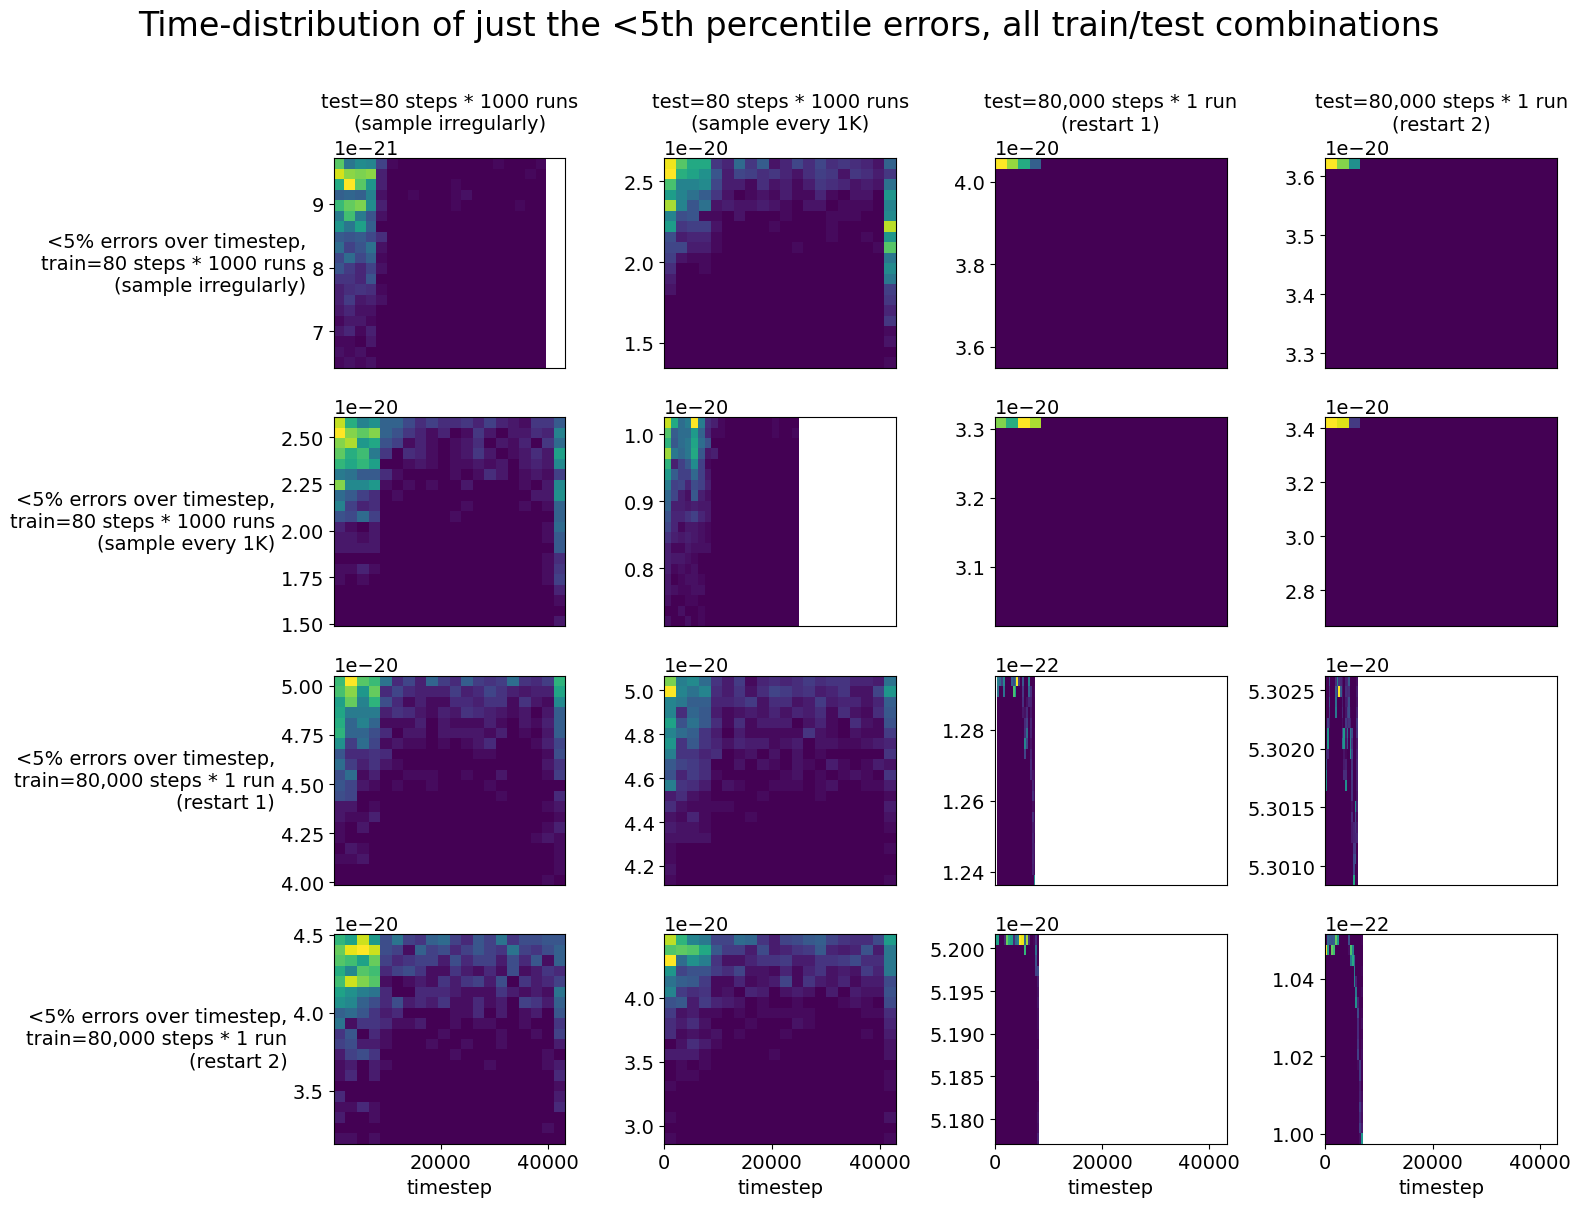

In [12]:
with figure_grid(4,4,rowwidth=16) as g:
    g.title("Time-distribution of just the <5th percentile errors, all train/test combinations", fontsize=24, y=0.98)
    for i, m2 in enumerate(sorted(dirs)):
        for j, m1 in enumerate(sorted(dirs)):
            g.next()
            if j == 0:
                plt.ylabel(f'<5% errors over timestep,\ntrain={label_for(m2)}', rotation=0, ha='right', va='center')
            if i == 0:
                plt.title(f'test={label_for(m1)}',y=1.1, fontsize=14)
                
            pct = np.percentile(errors[m1][m2], 5)
            idx = np.argwhere(errors[m1][m2] < pct)[:,0]
            
            plt.hist2d(times[m1][idx], errors[m1][m2][idx], bins=20)
            #
            if i == 3:
                plt.xlabel('timestep')
            else:
                plt.xticks([])
            plt.xlim(times[m1].min(), times[m1].max())

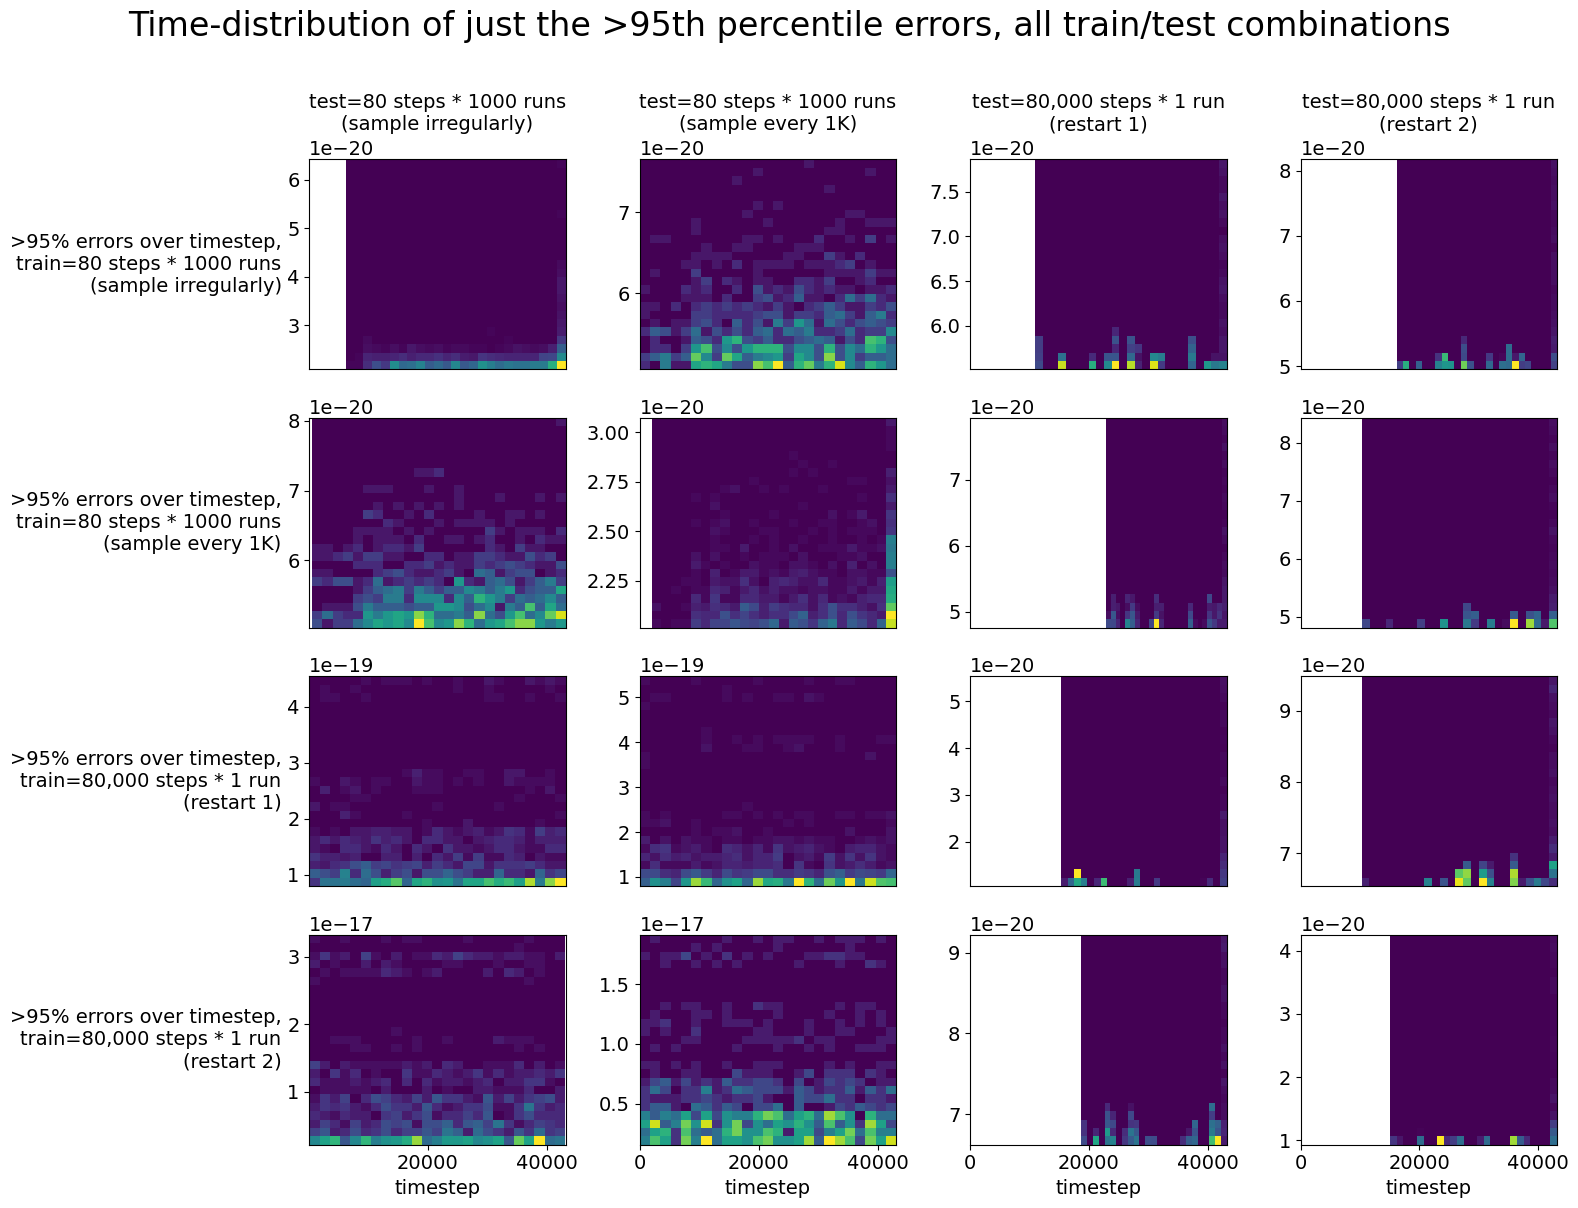

In [13]:
with figure_grid(4,4,rowwidth=16) as g:
    g.title("Time-distribution of just the >95th percentile errors, all train/test combinations", fontsize=24, y=0.98)
    for i, m2 in enumerate(sorted(dirs)):
        for j, m1 in enumerate(sorted(dirs)):
            g.next()
            if j == 0:
                plt.ylabel(f'>95% errors over timestep,\ntrain={label_for(m2)}', rotation=0, ha='right', va='center')
            if i == 0:
                plt.title(f'test={label_for(m1)}',y=1.1, fontsize=14)
                
            pct = np.percentile(errors[m1][m2], 95)
            idx = np.argwhere(errors[m1][m2] > pct)[:,0]
            
            plt.hist2d(times[m1][idx], errors[m1][m2][idx], bins=25)
            #
            if i == 3:
                plt.xlabel('timestep')
            else:
                plt.xticks([])
            plt.xlim(times[m1].min(), times[m1].max())

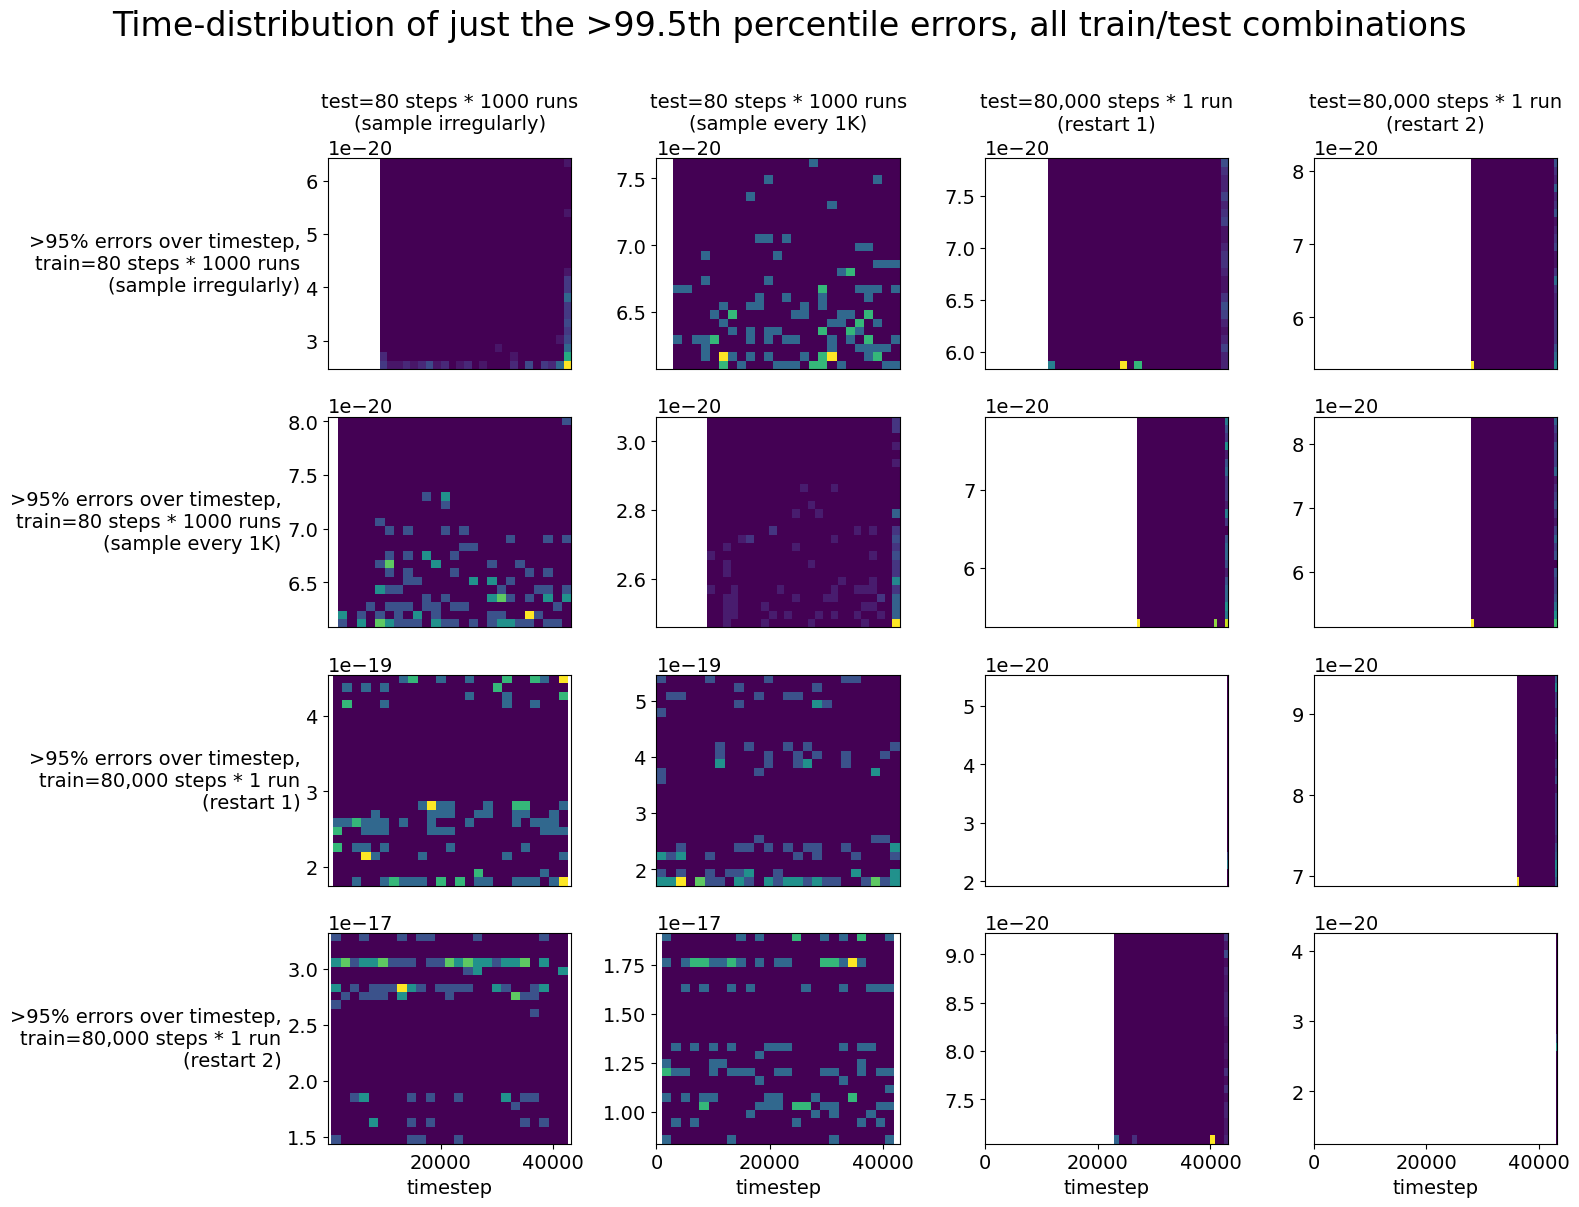

In [14]:
with figure_grid(4,4,rowwidth=16) as g:
    g.title("Time-distribution of just the >99.5th percentile errors, all train/test combinations", fontsize=24, y=0.98)
    for i, m2 in enumerate(sorted(dirs)):
        for j, m1 in enumerate(sorted(dirs)):
            g.next()
            if j == 0:
                plt.ylabel(f'>95% errors over timestep,\ntrain={label_for(m2)}', rotation=0, ha='right', va='center')
            if i == 0:
                plt.title(f'test={label_for(m1)}',y=1.1, fontsize=14)
                
            pct = np.percentile(errors[m1][m2], 99.5)
            idx = np.argwhere(errors[m1][m2] > pct)[:,0]
            
            plt.hist2d(times[m1][idx], errors[m1][m2][idx], bins=25)
            #
            if i == 3:
                plt.xlabel('timestep')
            else:
                plt.xticks([])
            plt.xlim(times[m1].min(), times[m1].max())

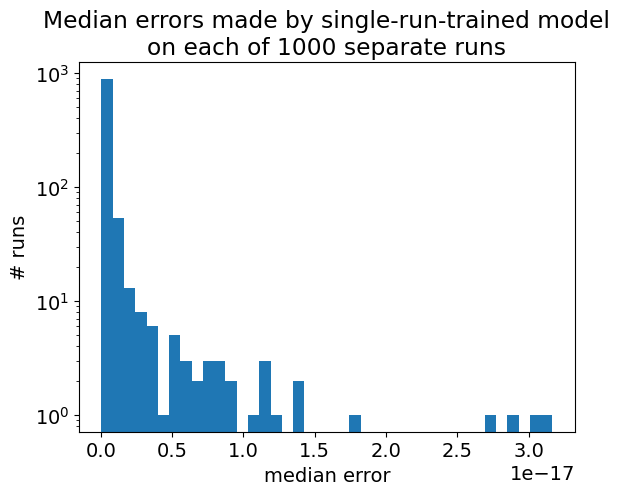

In [15]:
trn = 'single_run_all_steps2'
tst = 'many_runs_few_steps_irregular'

errs = errors[tst][trn]
plt.title("Median errors made by single-run-trained model\non each of 1000 separate runs")
plt.hist([np.median(errs[np.argwhere(runs[tst]==i)[:,0]]) for i in range(1000)], bins=40)
plt.xlabel('median error')
plt.ylabel('# runs')
plt.yscale('log')
plt.show()

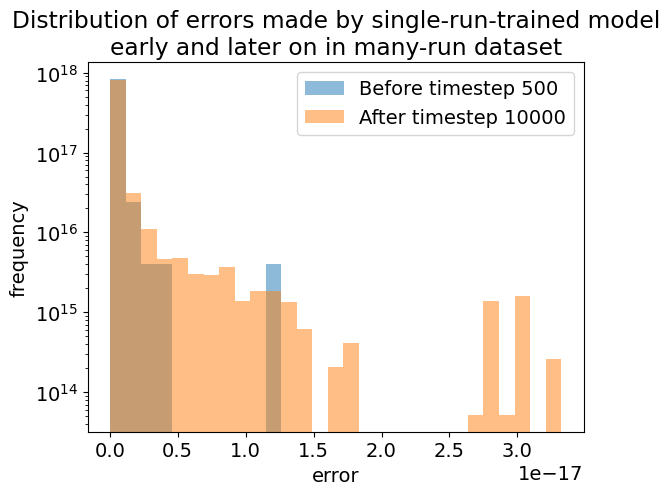

In [16]:
plt.title("Distribution of errors made by single-run-trained model\nearly and later on in many-run dataset")

errs = errors[tst][trn]
idx1 = np.argwhere(times[tst] < 500)[:,0]
idx2 = np.argwhere(times[tst] > 10000)[:,0]

bins = np.linspace(errs.min(), errs.max(), 30)

plt.hist(errs[idx1], alpha=0.5, label="Before timestep 500", density=True, bins=bins)
plt.hist(errs[idx2], alpha=0.5, label="After timestep 10000", density=True, bins=bins)
plt.yscale('log')
plt.legend()
plt.xlabel('error')
plt.ylabel('frequency')
plt.show()

In [31]:
trn = 'single_run_all_steps2'
tst = 'many_runs_few_steps_irregular'

bad_pred_idxs = np.argwhere(errors[tst][trn] > errors[tst][trn].max() * 0.9)[:,0]
good_pred_idxs = np.argwhere(errors[tst][trn] < errors[tst][trn].min() * 1.1)[:,0]

model = [m for m,d in zip(models,dirs) if d==trn][0]
ds = [ds for ds in datasets if ds.name == tst][0]

order = ds.persistent_order
split_at = int(len(ds.dataset.coarse_data.potential_vorticity)*0.25)
train = order[split_at:]
test = order[:split_at]

bad_q = ds.to_np(ds.dataset.coarse_data.potential_vorticity[test[bad_pred_idxs]])
bad_Sq = ds.to_np(ds.dataset.forcing_data.potential_vorticity[test[bad_pred_idxs]])
bad_Sqhat = model.predict(bad_q)

good_q = ds.to_np(ds.dataset.coarse_data.potential_vorticity[test[good_pred_idxs]])
good_Sq = ds.to_np(ds.dataset.forcing_data.potential_vorticity[test[good_pred_idxs]])
good_Sqhat = model.predict(good_q)

len(bad_pred_idxs), len(good_pred_idxs)

(51, 19)

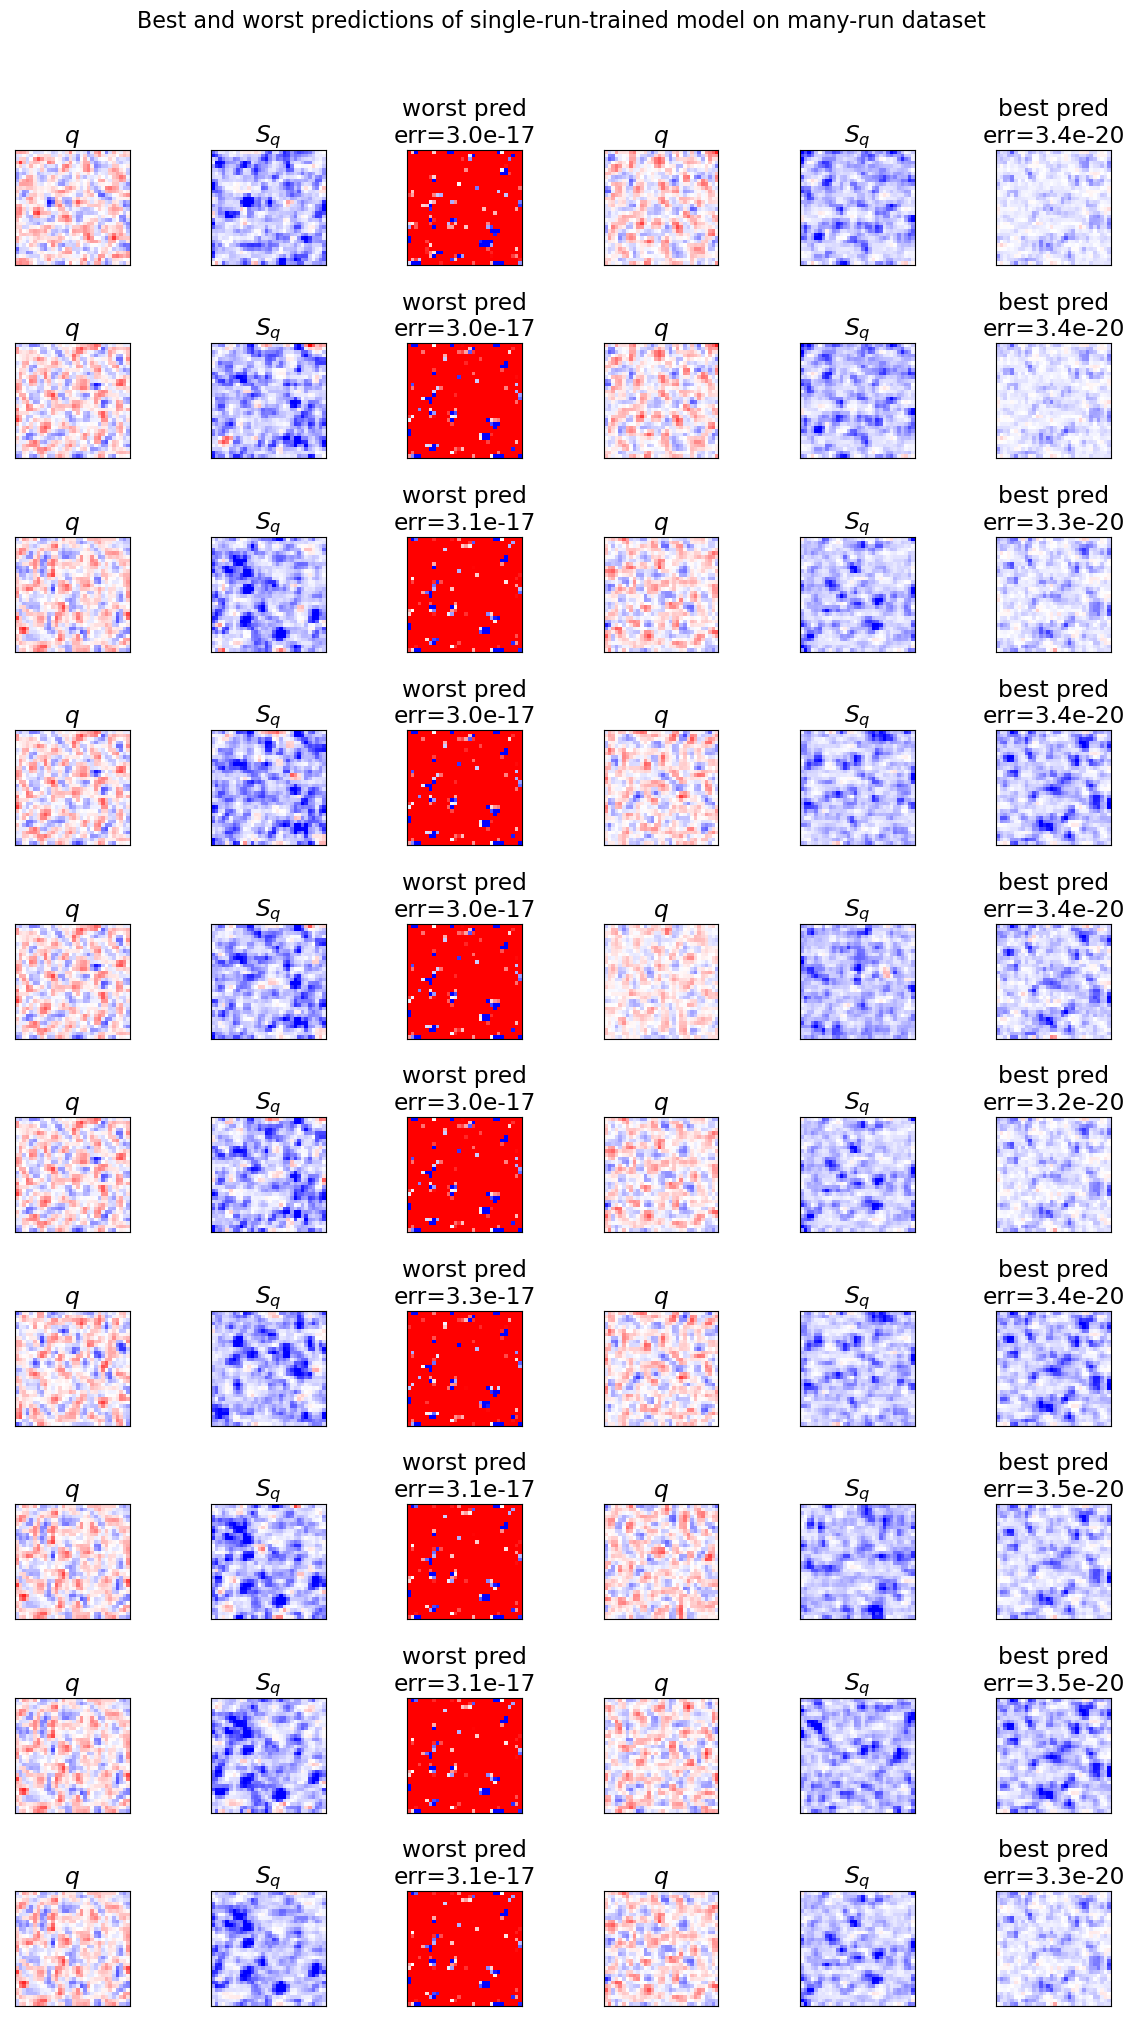

In [32]:
to_show=10

def imshow(x, vlim=2e-11):
    plt.imshow(x.reshape(32,32), cmap='bwr', vmin=-vlim, vmax=vlim)
    plt.xticks([])
    plt.yticks([])
    
with figure_grid(to_show,6,rowheight=2) as g:
    g.title("Best and worst predictions of single-run-trained model on many-run dataset")
    for i in range(to_show):
        g.next(title="$q$"); imshow(bad_q[i], vlim=1e-5)
        g.next(title="$S_q$"); imshow(bad_Sq[i])
        err = errors[tst][trn][bad_pred_idxs[i]]
        g.next(title=f"worst pred\nerr={err:.1e}"); imshow(bad_Sqhat[i])
        
        g.next(title="$q$"); imshow(good_q[i], vlim=1e-5)
        g.next(title="$S_q$"); imshow(good_Sq[i])
        err = errors[tst][trn][good_pred_idxs[i]]
        g.next(title=f"best pred\nerr={err:.1e}"); imshow(good_Sqhat[i])

In [27]:
trn = 'many_runs_few_steps_irregular'
tst = 'many_runs_few_steps_uniform'

bad_pred_idxs = np.argwhere(errors[tst][trn] > errors[tst][trn].max() * 0.9)[:,0]
good_pred_idxs = np.argwhere(errors[tst][trn] < errors[tst][trn].min() * 1.3)[:,0]

model = [m for m,d in zip(models,dirs) if d==trn][0]
ds = [ds for ds in datasets if ds.name == tst][0]

order = ds.persistent_order
split_at = int(len(ds.dataset.coarse_data.potential_vorticity)*0.25)
train = order[split_at:]
test = order[:split_at]

bad_q = ds.to_np(ds.dataset.coarse_data.potential_vorticity[test[bad_pred_idxs]])
bad_Sq = ds.to_np(ds.dataset.forcing_data.potential_vorticity[test[bad_pred_idxs]])
bad_Sqhat = model.predict(bad_q)

good_q = ds.to_np(ds.dataset.coarse_data.potential_vorticity[test[good_pred_idxs]])
good_Sq = ds.to_np(ds.dataset.forcing_data.potential_vorticity[test[good_pred_idxs]])
good_Sqhat = model.predict(good_q)

len(bad_pred_idxs), len(good_pred_idxs)

(13, 16)

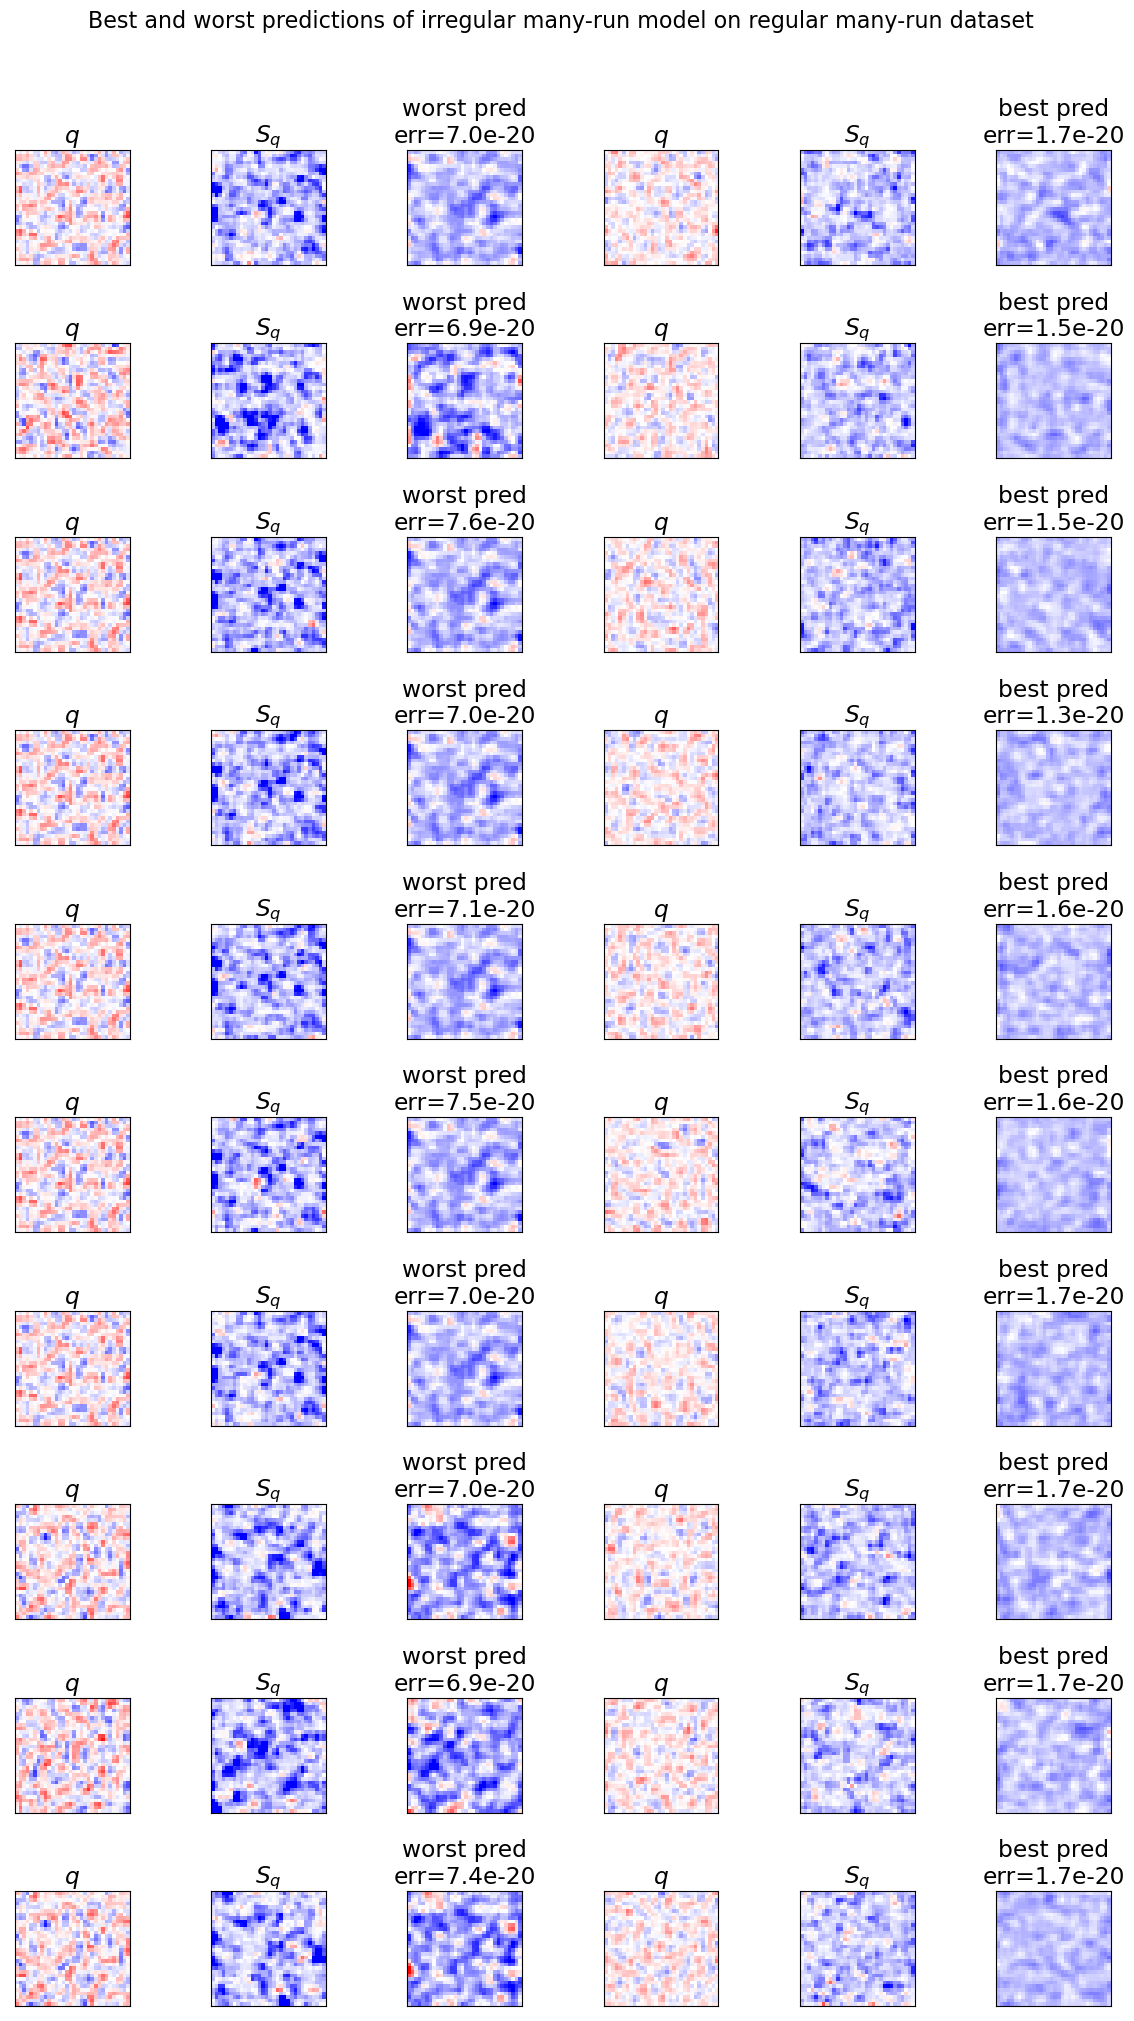

In [30]:
with figure_grid(to_show,6,rowheight=2) as g:
    g.title("Best and worst predictions of irregular many-run model on regular many-run dataset")
    for i in range(to_show):
        g.next(title="$q$"); imshow(bad_q[i], vlim=1e-5)
        g.next(title="$S_q$"); imshow(bad_Sq[i])
        err = errors[tst][trn][bad_pred_idxs[i]]
        g.next(title=f"worst pred\nerr={err:.1e}"); imshow(bad_Sqhat[i])
        
        g.next(title="$q$"); imshow(good_q[i], vlim=1e-5)
        g.next(title="$S_q$"); imshow(good_Sq[i])
        err = errors[tst][trn][good_pred_idxs[i]]
        g.next(title=f"best pred\nerr={err:.1e}"); imshow(good_Sqhat[i])